# Predicting the tides

### Introduction

Now that we have become familiar with how the fourier series decomposition works, it is time to apply the principles to our tide prediction problem. Step one is to get our hands on some historical data.

### Historical tide levels in Ålesund

Now that we have an idea of what time interval of tide measurements to analyze, it is time to get our hands on some actual measurements. Attached to this exercise is a python module with functions to download tidal measurements taken in Ålesund at **10** minute intervals up until **23:50** last night. The input argument `N_days_recorded` defines the lenght of the historical log in days. The data is sourced from Kartverket.

<!--. One well known early use of Fourier Series relates to predicting ocean tide levels. Back in the 19th century the vast majority of transportation was done by sea, and having access to reliable prediction for tide levels in different port locations was highly desirable.

In 1867, William Thompson (Lord Kelvin) developed a method for predicting tide levels by calculating the sum of a numbuer of sinusoids. This was accomplished by subjecting historical tide measurements to Fourier Series decomposition, and then using the resulting fourier series to generate a tide prediction as a mathematical function.

[Figure]

As we know, fourier series decomposition involves analyzing a periodic function $x(t)$ over a period of time known as the fundamental period $T$ as illustrated above. The idea being that once you can find a function to describe mathematically the values of $x(t)$ within the time frame $0 \leq t < T$, the value of $x(t)$ for any other point in time can be easily extrapolated due to the repeating nature of the function $x(t)$. 

In practice few real-world phenomena can be modeled perfectly as periodic functions, but tide levels which are governed primarily by rotations of the earth and moon come pretty close. Seeing as a [lunar day](https://en.wikipedia.org/wiki/Lunar_day) corresponds to *approximately* $29 \frac{1}{2}$ day, one suggestion for choice of fundamental-ish period $T$ for use in fourier analysis is $59 \text{ earth days} \approx 2 \text{ lunar days}$.

### Historical tide levels in Ålesund

Now that we have an idea of what time interval of tide measurements to analyze, it is time to get our hands on some actual measurements. Attached to this exercise is a python module with functions to download tidal measurements taken at **10** minute intervals up until **00:00** last night. Input arguments are location and observation period. The data is sourced from Kartverket. -->

In [1]:
from module2functions import getTideObservations
N_days_recorded = 59 # This is a suggestion, feel free to adjust if desired.
measurements_cm, meas_freq, from_date, to_date = getTideObservations(N_days_recorded)

The function `getTideObservations` has 4 return values:
* `measurements_cm`: An array contaning all the sea level measurements in centimeters relative to mean sea level.
* `meas_freq`: Number of measurements per day
* `from_date`: First day of measurement series
* `to_date`: Last day of measurement series

These values will make up the basis of our tide predictions. Before we do this though, it may be useful to analyze the measurements graphically, both in the time and frequency domain. The codecell below will produce interactive plots of both the sea level time series as well as the magnitude spectrum. 

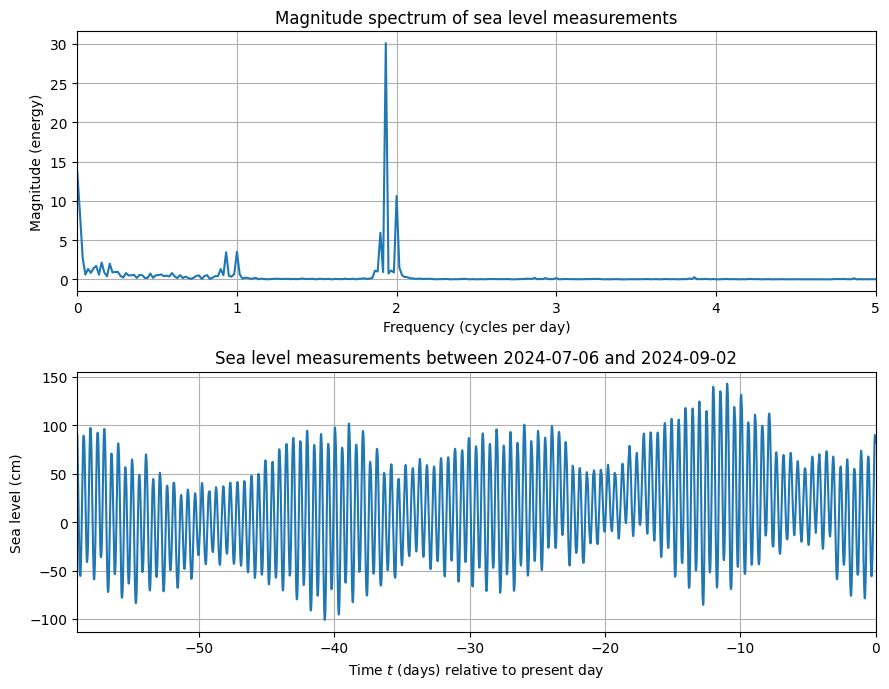

In [2]:
import matplotlib.pyplot as plt
import numpy as np
#%matplotlib ipympl

Fs = meas_freq # Sampling frequency
plt.figure(figsize=(9,7))
plt.subplot(2,1,1)
plt.magnitude_spectrum(measurements_cm, # Array of tide observations in cm
                       Fs=meas_freq, # Measurements per day
                       window=np.ones(len(measurements_cm)) # Will be covered in exercise 4
                      )
plt.xlim([0, 5]) # Focusing on lower end of frequency spectrum
plt.title("Magnitude spectrum of sea level measurements")
plt.xlabel("Frequency (cycles per day)")
plt.grid(True)
plt.subplot(2,1,2)

t_past = np.linspace(-N_days_recorded, 0, N_days_recorded*meas_freq, endpoint=False)
plt.plot(t_past, measurements_cm)
plt.xlim([-N_days_recorded, 0])
plt.xlabel("Time $t$ (days) relative to present day")
plt.ylabel("Sea level (cm)")
plt.title(f"Sea level measurements between {from_date} and {to_date}")
plt.grid(True)
plt.tight_layout()

As we can see from the graphical plots, most of the signal energy is confined to a set of different frequencies. We *could* identify these by inspecting the magnitude plot, but they are determined by orbital mechanics and have already been calculated quite precisely.

The 5 most prominent perids are: $\{ 12.42\text{h}, 12.00\text{h}, 12.66\text{h}, 23.93\text{h}, 25.82\text{h}\} $. You can find more of them [here](https://geo.libretexts.org/Bookshelves/Oceanography/Coastal_Dynamics_(Bosboom_and_Stive)/03%3A_Ocean_waves/3.07%3A_Generation_of_the_tide/3.7.6%3A_Tidal_constituents) if you want.

## a)

Use what you learned in tasks **1-3** to extract the magnitude and phase of the most prominent frequency components. You can confine yourself to the 5 listed above, or select a larger number.

*PS. Tasks **a)** and **b)** should share a common reference time for both the historical log and the predictions. It is strongly suggested you use midnight ($00:00$) last night as reference ($t=0$).*

*PPS. We are sadly not observing the data over a perfect fundamental period. As such, we can't rely on the integral of all other frequency components to equal zero. However, the longer the data set, the closer to zero the mean values for the other frequency components will become.*

In [3]:
# WRITE YOUR CODE HERE:
frequency = 24/ np.array([12.42, 12.00, 12.66, 23.93, 25.82])

def extract_sinusoid(x, t, f):
    z = x * np.exp(-2j * np.pi * f * t)
    mean_z = np.mean(z)
    
    mag_f = 2 * np.abs(mean_z)
    phase_f = np.angle(mean_z)
    return mag_f, phase_f

mags, phases = [], []
for f in frequency:
    mag, phase = extract_sinusoid(measurements_cm, t_past, f)
    mags.append(mag)
    phases.append(phase)


for i, f in enumerate(frequency):
    print(f"Frequency: {f:.2f} cycles/day, Magnitude: {mags[i]:.2f}, Phase: {phases[i]:.2f}")


Frequency: 1.93 cycles/day, Magnitude: 60.10, Phase: 0.88
Frequency: 2.00 cycles/day, Magnitude: 21.22, Phase: -0.24
Frequency: 1.90 cycles/day, Magnitude: 11.79, Phase: -1.21
Frequency: 1.00 cycles/day, Magnitude: 7.23, Phase: 1.43
Frequency: 0.93 cycles/day, Magnitude: 7.33, Phase: 1.63


## b)
Use the information you extracted in task **a)** to create a new array containing predictions for the next $14$ days. (i.e. from 00:00 tonight up to 23:50 13 days from now). Store your predictions in the array `my_prediction`.<br>
*PS. make sure you calculate the function values for the correct time interval. When doing frequency analysis, the "start time" (i.e. $t=0$) was `N_days` days ago. The time interval should therefore be `N_days` $\leq t <$ `N_days` $+ 14$.*

In [12]:
days_to_predict = 14
# WRITE YOUR CODE HERE:

t_future = np.linspace(N_days_recorded, N_days_recorded + days_to_predict, int(days_to_predict * 24 * 6), endpoint=False)
t_future = t_future - N_days_recorded

tide_prediction = np.zeros_like(t_future)
for i, f in enumerate(frequency):
    tide_prediction += mags[i] * np.cos(2 * np.pi * f * t_future + phases[i])


### Evaluating your tide prediction

The code cell below will acquire tide level predictions from Kartverket, and plot them next to the predictions you have made and stored in the variable `tide_prediction`. While not identical, you should definitely see a strong correlation between your predictions and those available from Kartverket. [This](Figurer/tide_predictions.png) is what it looked like when i compared the two .

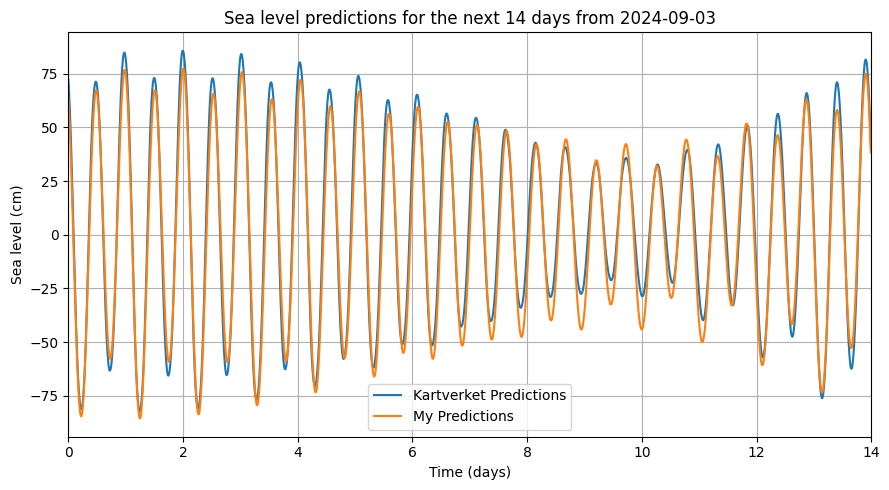

In [13]:
import matplotlib.pyplot as plt
from module2functions import getTidePredictions

predictions_kartverket, pred_freq, from_date, to_date = getTidePredictions(days_to_predict)

plt.figure(figsize=(9, 5))
plt.plot(t_future, predictions_kartverket, label="Kartverket Predictions")
plt.xlim([0, days_to_predict])
plt.xlabel("Time (days)")
plt.ylabel("Sea level (cm)")
plt.title(f"Sea level predictions for the next {days_to_predict} days from {from_date}")
plt.grid(True)
plt.plot(t_future, tide_prediction, label="My Predictions")
plt.legend()
plt.tight_layout()
